In [47]:
# -------------------------------------------------------------- #
#   d8,                                                          #
#  `8P                                             d8P           #
#                                               d888888P         #
#   88b  88bd8b,d88b ?88,.d88b, d8888b   88bd88b  ?88'   .d888b, #
#   88P  88P'`?8P'?8b`?88'  ?88d8P' ?88  88P'  `  88P    ?8b,    #
#  d88  d88  d88  88P  88b  d8P88b  d88 d88       88b      `?8b  #
# d88' d88' d88'  88b  888888P'`?8888P'd88'       `?8b  `?888P'  #
#                     88P'                                       #
#                    d88                                         #
#                    ?8P                                         #
# -------------------------------------------------------------- #

import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

In [48]:
## WARNING 'BBT' and 'STI' merged into 'TFC' ##
## We use 'TFC' as a replacement for 'BBT' ##
## We use Fifth Third Bankcorp 'FITB' as a replacement for STI ##

a_tickers = ["JPM", "WFC", "BAC", "C", "GS", "USB", "MS", "KEY", "PNC", "COF", "AXP", "PRU", "SCHW", "TFC", "FITB"]
#a_data = yf.download(a_tickers, start="2008-09-01", end="2008-10-31")
#print(a_data)

In [49]:
## WARNING ticker 'HCP' is now 'DOC' ##

b_tickers = ["KR", "PFE", "XOM", "WMT", "DAL", "CSCO", "DOC", "EQIX", "DUK", "NFLX", "GE", "APA", "F", "REGN", "CMS"]
#b_data = yf.download(b_tickers, start="2008-09-01", end="2008-10-31")
#print(b_data)

In [50]:
c_tickers = a_tickers + b_tickers
data = yf.download(c_tickers, start="2008-09-01", end="2009-09-01")["Adj Close"]
daily_return = data.pct_change()
#print(data.head())

[*********************100%***********************]  30 of 30 completed


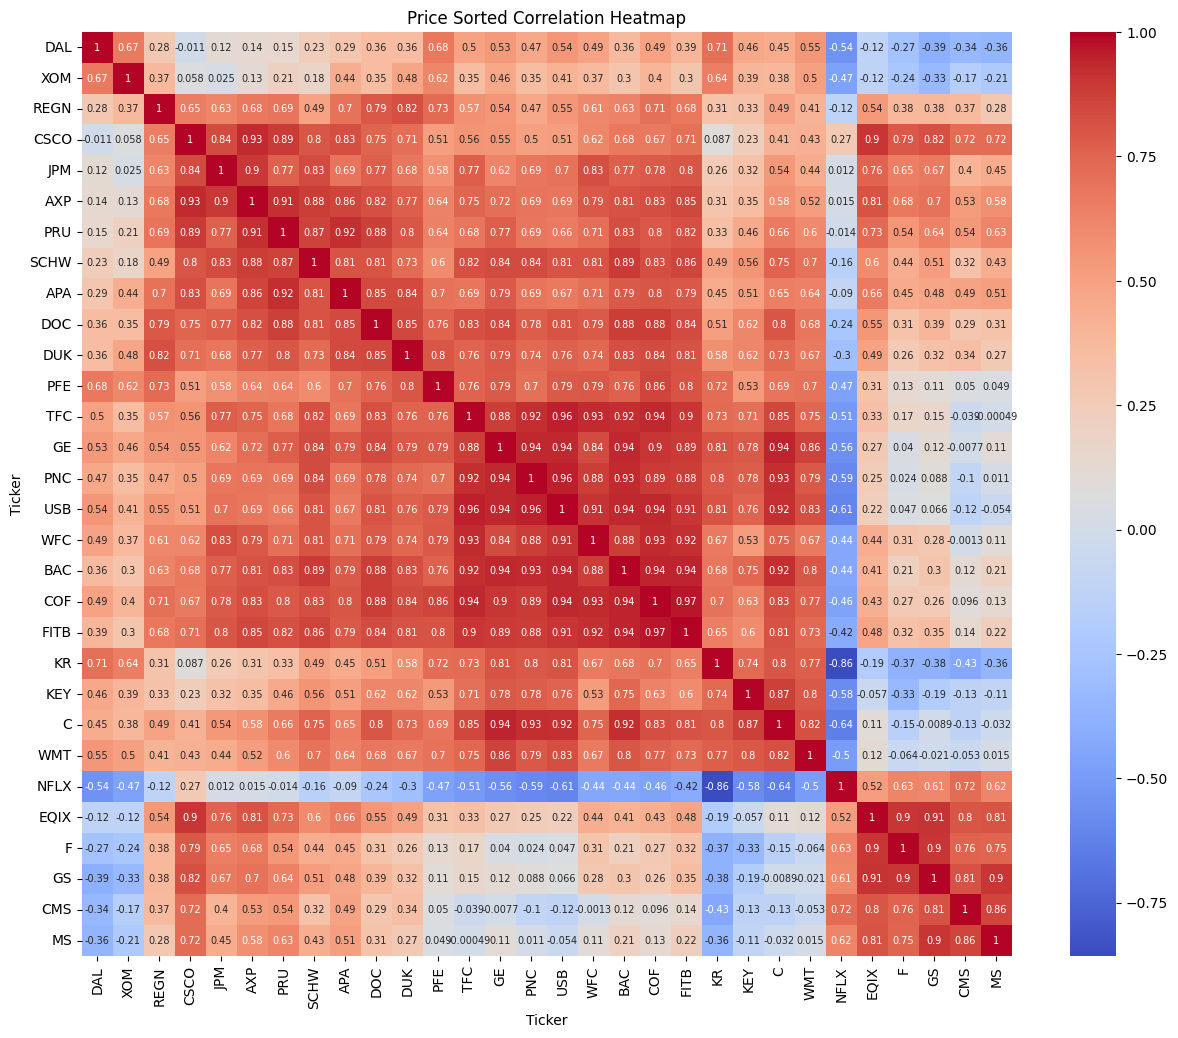

In [51]:
corr = data.corr()

# Use hierarchical clustering to reorder the correlation matrix
linkage_matrix = linkage(corr, method='average')
sorted_index = leaves_list(linkage_matrix)

# Reorder the correlation matrix
sorted_corr = corr.iloc[sorted_index, sorted_index]

# Plot the sorted heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(sorted_corr, cmap='coolwarm', annot=True, annot_kws={"size": 7})
plt.title("Price Sorted Correlation Heatmap")
plt.show()

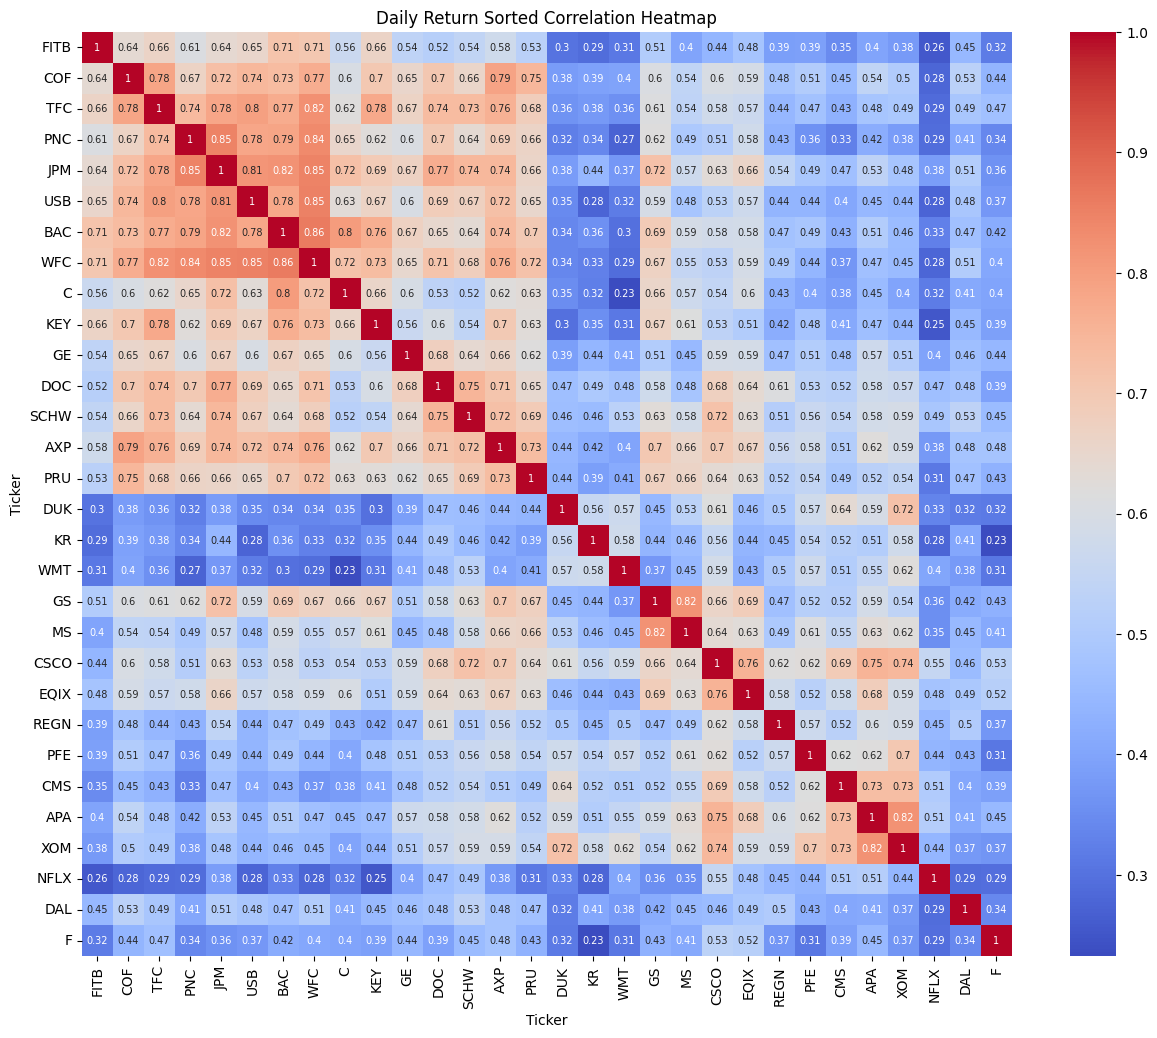

In [52]:
corr = daily_return.corr()

# Use hierarchical clustering to reorder the correlation matrix
linkage_matrix = linkage(corr, method='average')
sorted_index = leaves_list(linkage_matrix)

# Reorder the correlation matrix
sorted_corr = corr.iloc[sorted_index, sorted_index]

# Plot the sorted heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(sorted_corr, cmap='coolwarm', annot=True, annot_kws={"size": 7})
plt.title("Daily Return Sorted Correlation Heatmap")
plt.show()

___________

# Step 2:
### Write psuedocode for **Model 1:** Sequential portfolio selection problem:

1) Recieve historical returns $H_{i, t}$ of each asset starting from $t=1$.
2) **for** every time-step starting from $t=1$, make the optimal selection:

$\qquad \qquad$ a) Choose portfolio weights $\omega_t = (\omega_{1, t}, \cdots, \omega_{K, t})^T$ for each of the $K$ assets.

$\qquad \qquad$ b) Observe the returns $R_t = (R_{1, t}, \cdots, R_{K, t})$ for $K$ assets and collect reward $\omega_t^T R_t$

__________

# Step 3:


Number of days = 251
Number of stocks = 30


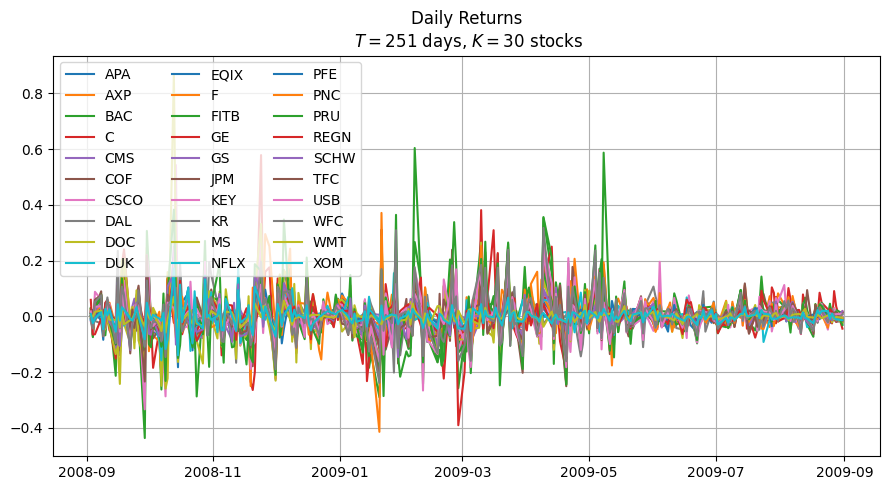

In [53]:
daily_return = daily_return.dropna()
daily_return

plt.figure(figsize=(9, 5))
plt.plot(daily_return, label=daily_return.columns)
plt.title("Daily Returns\n $T=251$ days, $K=30$ stocks")
plt.legend(loc='upper left', ncol=3)
plt.grid()
plt.tight_layout()

print("Number of days =", daily_return.shape[0])
print("Number of stocks =", daily_return.shape[1])

____________

# Step 6:

We are going to build-up a **UCB** (Upper Confidence Bound) algorithm for the <u> single stock picking</u> problem, as mentioned in the lesson notes. For reminder, we quote the definition of **UCB** from Module 6, Lesson 4 notes:

    ... to prioritize the exploration of actions that we are more uncertain about, we can  follow the next optimal choice:
$$
\begin{equation}
A_t = \arg\underset{a}{\max} \left\{Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}}\right\}
\end{equation}
$$
    where the new term adjusts for the degree of "unexploration" of the action relative to the steps completed. The parameter c > 0 controls the degree of exploration. If N_t(a) = 0, a is considered to be a maximizing action to avoid the ratio to be infinite.

### a. Member A writes pseudocode that describes the UBC algorithm:

* We have $30$ different stocks to choose from, let $s^{(i)}$ be the stock at index $i$ in our ticker list for $i = 1, 2, \cdots, K$ where $K=30$ in this project.

* Let $S^{(i)}_t$ be the price of stock $s^{(i)}$ at time $t$.

* Let $R^{(i)}_t= log(\Large\frac{S^{(t)}}{S^{(t-1)}}\normalsize)$ be the return of stock $s^{(i)}$ at time $t$.

* Let $A_t$ be the **stock picking action** we choose according to the **UCB** algorithm at time $t$ for $t = 1, 2, \cdots, T$ where $T=251$ in this project.

* Let $N^{(i)}_t$ be the number of times stock $s_i$ is selected at time $t$.

* Because if $N_t(s^{(j)})=0$ we define $s^{(j)}$ to be the optimal stock picking and we break ties arbitrarily between optimum actions, after we start the algorithm the first $30$ actions will be picking each stock once until all stocks are chosen once.

*> psuedocode start*

**Initialize** $Q_0(s_j) = 0$ for all $j = 1, \cdots, 30$

**for** $t=1, \cdots, 30$ **do:**

1) Choose $A_t = s^{(t)}$, where $s^{(t)}$ is stock with index $t$ in tickers list.
2) Observe $R^{(t)}_t = ln(\frac{S^{(t)}_t}{S^{(t)}_{t-1}}\normalsize)$ and recieve reward $R^{(t)}_t$.
3) Update $Q_t(s^{(t)}) \leftarrow Q_0(s^{(t)}) + \alpha (R^{(t)}_t - Q_0(s^{(t)}))$, where $\alpha$ parameter is the 'stepsize' parameter.
4) Update $N_t(s^{(t)}) \leftarrow N_{t-1}(s^{(t)}) + 1$

**end**

**for** $t=31, \cdots, 251$ **do:**

1) Choose $A_t = \arg\underset{s_j}{\max} \left\{Q_t(s^{(j)}) + c \sqrt{\frac{\ln(t)}{N_t(s^{(j)})}}\right\}$, where $s_{j^*}$ is the stock selection that maximizes $Q_t(s_j) + c \sqrt{\frac{\ln(t)}{N_t(s^{(j)})}}$
2) Observe $R^{(j^*)}_t = ln(\frac{S^{(j^*)}_t}{S^{(j^*)}_{t-1}}\normalsize)$ and recieve reward $R^{(j^*)}_t$.
3) Update $Q_t(s^{(j^*)}) \leftarrow Q_{t-1}(s^{(j^*)}) + \alpha (R^{(j^*)}_t - Q_{t-1}(s^{(j^*)}))$, where $\alpha$ is the 'stepsize' parameter.
4) Update $N_t(s^{(j^*)}) \leftarrow N_{t-1}(s^{(j^*)}) + 1$

**end**

*> psuedocode end*

### b, c. Implementation and Comments

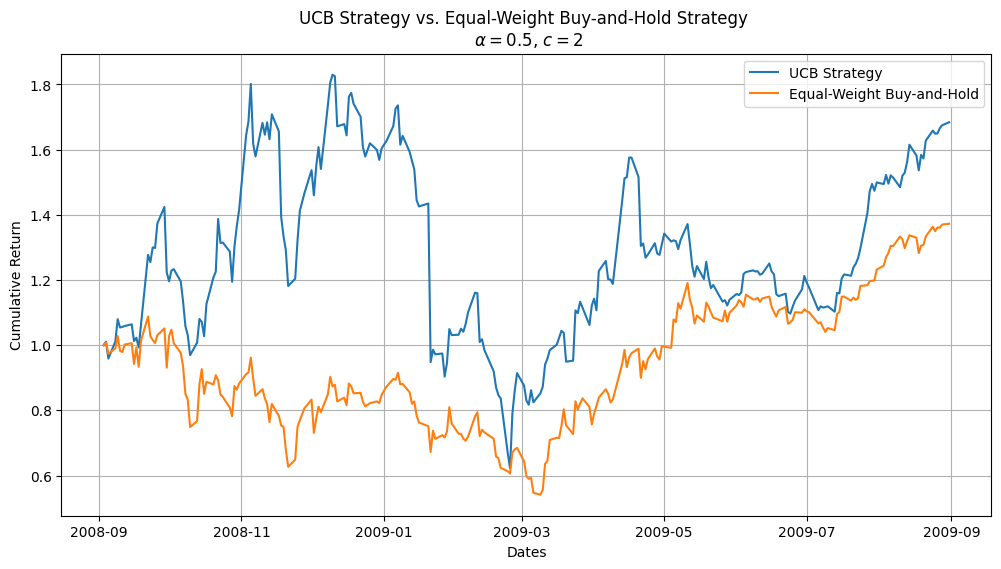

In [64]:
# Parameters
T, K = daily_return.shape
alpha = 0.5   # Step size parameter (learning rate)
c = 2         # Exploration parameter for UCB

# Initialize Q-values and action counts
Q_values = np.zeros(K)       # Estimated value (expected return) for each stock
N_actions = np.zeros(K)      # Number of times each stock has been selected

# Lists to store cumulative returns
ucb_cumulative_returns = [0]         # Cumulative log returns for UCB strategy
buy_and_hold_returns = [0]           # Cumulative log returns for buy-and-hold strategy

# Initialize cumulative return for buy-and-hold strategy
buy_and_hold_cum_return = 0

# Calculate daily returns for equal-weight buy-and-hold strategy
buy_and_hold_daily_returns = daily_return.mean(axis=1)

# UCB Algorithm Implementation
for t in range(T):
    if t < K:
        # Initialization phase: select each stock once
        action = t  # Select the t-th stock
    else:
        # Compute UCB values for each stock
        ucb_values = Q_values + c * np.sqrt(np.log(t + 1) / N_actions)
        # Select the stock with the highest UCB value
        action = np.argmax(ucb_values)
    
    # Observe reward (return) for the selected stock at time t
    reward = daily_return.iloc[t, action]
    
    # Update action count for the selected stock
    N_actions[action] += 1
    
    # Update Q-value (expected return) for the selected stock
    Q_values[action] = Q_values[action] + alpha * (reward - Q_values[action])
    
    # Update cumulative return for UCB strategy
    new_ucb_cum_return = ucb_cumulative_returns[-1] + reward  # Sum of log returns
    ucb_cumulative_returns.append(new_ucb_cum_return)
    
    # Update cumulative return for buy-and-hold strategy
    buy_and_hold_cum_return += buy_and_hold_daily_returns.iloc[t]  # Sum of log returns
    buy_and_hold_returns.append(buy_and_hold_cum_return)

# Prepare data for plotting
days = daily_return.index

ucb_cumulative_returns = np.array(ucb_cumulative_returns)[:-1]
buy_and_hold_returns = np.array(buy_and_hold_returns)[:-1]

# Convert cumulative log returns to cumulative returns
ucb_cumulative_returns_exp = np.exp(ucb_cumulative_returns)
buy_and_hold_returns_exp = np.exp(buy_and_hold_returns)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(days, ucb_cumulative_returns_exp, label='UCB Strategy')
plt.plot(days, buy_and_hold_returns_exp, label='Equal-Weight Buy-and-Hold')
plt.xlabel('Dates')
plt.ylabel('Cumulative Return')
plt.title(f'UCB Strategy vs. Equal-Weight Buy-and-Hold Strategy \n $\\alpha={alpha}$, $c={c}$')
plt.legend()
plt.grid(True)
plt.show()